# Bitcoin Linear Regression: LR Analysis
2 February 2018

This notebook assembles the LR model fromt the DataFrame pickle file generated in the DataFrame notebook.  

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

import warnings; warnings.simplefilter('ignore')
import json
import time
import sys
import re
import datetime

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import the pickled dataframe from BTC_DF
df = pd.read_pickle('data/benson_btcsentiment_df.pkl')
df = df[['BTCPrice','logBTCPrice','logETHPrice','logBTCVol','logTxFees','logCostperTxn','logNoTxns','logAvgBlkSz','logUniqueAddresses','logHashRate','logCrypto Market Cap','logNasdaq','logGold','logInterest','Interest','TxFees','Nasdaq']]
df_all = df
df_hist = df
df.head(2)


,BTCPrice,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,Interest,TxFees,Nasdaq
2016-07-13,656.669626,6.487181,2.356126,13.677656,10.454313,1.738710,12.296982,-0.261365,12.847761,14.232219,23.229166,8.518339,5.425787,1.098612,3.0,34693.7,5005.73
2016-07-14,656.132060,6.486362,2.350422,13.679501,10.469753,1.621366,12.292677,-0.210721,12.813804,14.136909,23.229166,8.523982,5.424421,1.098612,3.0,35233.5,5034.06


In [3]:
df.tail(2)

,BTCPrice,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,Interest,TxFees,Nasdaq
2018-01-31,10226.021308,9.232691,6.981842,12.837952,14.305632,4.572123,12.374164,-0.012570,13.183346,16.888655,27.084168,8.910785,5.199436,3.401197,30.0,1.632514e+06,7411.48
2018-02-01,9152.859852,9.121822,6.996681,13.308257,14.311633,4.388619,12.227227,0.041939,13.083830,16.532835,27.084168,8.907323,5.194567,3.401197,30.0,1.642340e+06,7385.86


In [4]:
# evaluate the correlation of the majority of features
df_all.corr().sort_values('logBTCPrice')

,BTCPrice,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,Interest,TxFees,Nasdaq
logBTCVol,-0.243063,-0.429054,-0.564208,1.000000,-0.469228,-0.456114,0.006265,-0.238191,-0.206054,-0.483225,-0.467636,-0.533240,-0.140050,-0.391439,-0.194954,-0.154349,-0.515549
logGold,-0.168917,-0.294323,-0.229241,-0.140050,-0.343744,-0.243655,-0.385409,-0.369890,-0.430605,-0.339648,-0.264825,-0.340306,1.000000,-0.339606,-0.197493,-0.105913,-0.321001
logNoTxns,0.441730,0.397574,0.248629,0.006265,0.489265,0.287141,1.000000,0.627928,0.860129,0.399457,0.328968,0.371145,-0.385409,0.452936,0.488041,0.417528,0.365985
logAvgBlkSz,0.526328,0.582375,0.507202,-0.238191,0.683472,0.496197,0.627928,1.000000,0.700798,0.550841,0.555269,0.600815,-0.369890,0.607600,0.501079,0.450945,0.598185
TxFees,0.871254,0.709695,0.582010,-0.154349,0.732571,0.701763,0.417528,0.450945,0.676200,0.622015,0.683536,0.601685,-0.105913,0.688179,0.803290,1.000000,0.620272
logUniqueAddresses,0.757943,0.765601,0.643276,-0.206054,0.819850,0.689856,0.860129,0.700798,1.000000,0.752252,0.716692,0.732690,-0.430605,0.792218,0.754412,0.676200,0.731813
Interest,0.935407,0.835541,0.687355,-0.194954,0.783112,0.804258,0.488041,0.501079,0.754412,0.747921,0.784246,0.721130,-0.197493,0.859418,1.000000,0.803290,0.736147
BTCPrice,1.000000,0.899874,0.756251,-0.243063,0.839987,0.878975,0.441730,0.526328,0.757943,0.825142,0.860010,0.794523,-0.168917,0.870562,0.935407,0.871254,0.814380
logETHPrice,0.756251,0.937390,1.000000,-0.564208,0.924451,0.950356,0.248629,0.507202,0.643276,0.929617,0.970651,0.943099,-0.229241,0.913437,0.687355,0.582010,0.942373
logTxFees,0.839987,0.958103,0.924451,-0.469228,1.000000,0.940794,0.489265,0.683472,0.819850,0.935102,0.955278,0.946667,-0.343744,0.957221,0.783112,0.732571,0.945148


In [5]:
# sns.set(style="darkgrid", color_codes=True)
# sns.pairplot(df_all)
# plt.savefig('charts/pairplotfeatureuniverse.png')

## The Core 3-Feature Model

In [6]:
# Reducing to few key features
df_all = df_all[['logBTCPrice','logNasdaq','logInterest','logTxFees']]
df_all.corr().sort_values('logBTCPrice')

,logBTCPrice,logNasdaq,logInterest,logTxFees
logTxFees,0.958103,0.946667,0.957221,1.000000
logNasdaq,0.958144,1.000000,0.944398,0.946667
logInterest,0.977745,0.944398,1.000000,0.957221
logBTCPrice,1.000000,0.958144,0.977745,0.958103


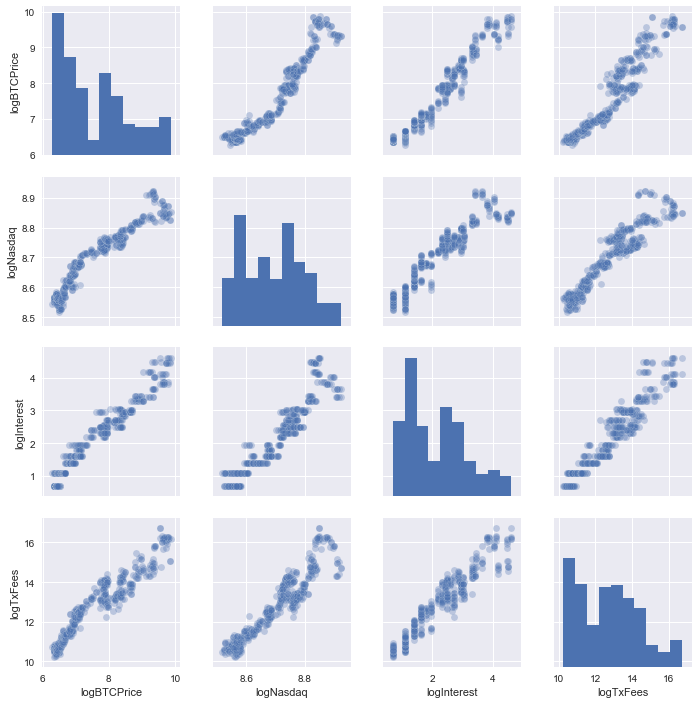

In [7]:
sns.set(style="darkgrid", color_codes=True)
sns.pairplot(df_all,plot_kws={'alpha':0.3})
# plt.title('Correlation by Feature',fontsize=14)
plt.savefig('charts/modelpairplot.png')

In [8]:
df = df_all
# STATSMODELS
# Feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('logBTCPrice ~ logInterest + logNasdaq + logTxFees', data=df, return_type="dataframe")

model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     4704.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        14:24:29   Log-Likelihood:                 128.03
No. Observations:                 467   AIC:                            -248.1
Df Residuals:                     463   BIC:                            -231.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -17.9952      2.286     -7.872      0.000     -22.488     -13.503
logInterest     0.5870      0.031     19.121      0.000       0.527       0.647
logNasdaq       2.6833      0.278      9.637      0.000       2.136       3.230
logTxFees       0.0795      0.020      3.951      0.000       0.040       0.119
==============================================================================
Omnibus:                        7.632   Durbin-Watson:                   0.202
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.217
Skew:                          -0.258   Prob(JB):                       0.0271
Kurtosis:                       2.677   Cond. No.                     4.22e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# SKLEARN
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X3 + X6 model
X = df[['logInterest','logNasdaq','logTxFees']]
# Choose the response variable(s)
y = df['logBTCPrice']

lr.fit(X,y)
# Print out the R^2 for the model against the full dataset
print(lr.score(X,y))
print(lr.intercept_)
print(lr.coef_)

0.9682354874769036
-17.995192980430755
[0.58695568 2.68331011 0.07948642]


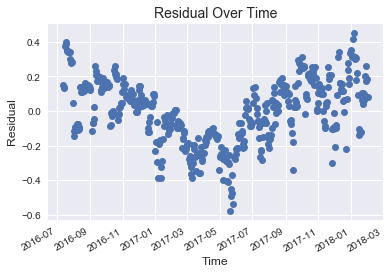

In [10]:
# Plotting residuals on a time series basis.
# Note that residuals are not random and will require further adjustments at a later time.  
fit.resid.plot(style='o');
plt.ylabel("Residual",fontsize=12)
plt.xlabel("Time",fontsize=12)
plt.title('Residual Over Time',fontsize=14)
plt.savefig('charts/residovertime.png')

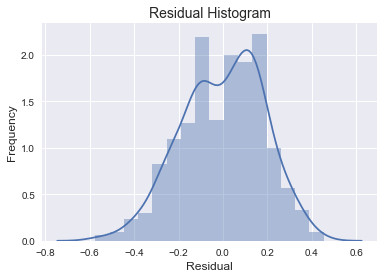

In [11]:
y_pred = lr.predict(X)

residuals = y - y_pred

sns.distplot(residuals);
plt.ylabel("Frequency",fontsize=12)
plt.xlabel("Residual",fontsize=12)
plt.title('Residual Histogram',fontsize=14)
plt.savefig('charts/residhist.png')

In [12]:
# TIME SERIES CROSS VALIDATION NOT INCLUDED IN THIS ANALYSIS (But may be incorporated later)
# The cross validation for a time series would be as follows:
# split = int(round(len(df) * 0.9,0))
# X_train, X_test, y_train, y_test = df.iloc[:split,1:], df.iloc[split:,1:],df.iloc[:split,0],df.iloc[split:,0]
# Due to project requirements, I am using the standard linear regression train-test split for this analysis.

In [13]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size = 0.7)

# Fit the model against the training data
lr.fit(X_train, y_train)
# # Evaluate the model against the testing data
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.9676258903239392
0.9694679269743363


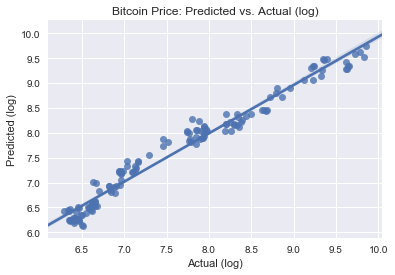

In [14]:
# sklearn prediction (logBTCPrice); seaborn
ax = sns.regplot(x=y_test,y=lr.predict(X_test), data=df)
ax.set(xlabel='Actual (log)', ylabel='Predicted (log)', title = 'Bitcoin Price: Predicted vs. Actual (log)')
plt.savefig('charts/logpredictedvsactual.png')

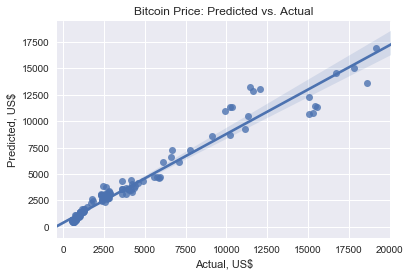

In [15]:
# sklearn prediction (BTCPrice); seaborn
ax = sns.regplot(x=np.exp(y_test),y=np.exp(lr.predict(X_test)), data=df)
ax.set(xlabel='Actual, US$', ylabel='Predicted, US$', title = 'Bitcoin Price: Predicted vs. Actual')
plt.savefig('charts/predictedvsactual.png')

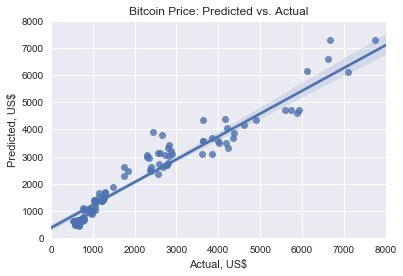

In [16]:
# limit x and y ticks to 8000 to see model prediction capability vs actual is near-aligned
ax = sns.regplot(x=np.exp(y_test),y=np.exp(lr.predict(X_test)), data=df)
ax.set(xlabel='Actual, US$', ylabel='Predicted, US$', title = 'Bitcoin Price: Predicted vs. Actual')
plt.xlim(0, 8000)
plt.ylim(0, 8000)
plt.savefig('charts/predictedvsactuallimits.png')

## Feature Analysis

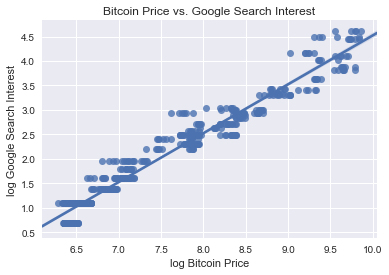

In [17]:
# GOOGLE SEARCH INTEREST
x = df['logBTCPrice']
y = df['logInterest']

ax = sns.regplot(x,y, data=df)
ax.set(xlabel='log Bitcoin Price', ylabel='log Google Search Interest', title = 'Bitcoin Price vs. Google Search Interest')
plt.savefig('charts/interestvsbtcprice.png')

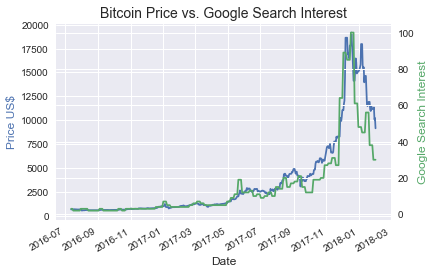

None


In [18]:
y1 = pd.Series(df_hist['BTCPrice'])
y2 = pd.Series(df_hist['Interest'])
x = pd.Series(df_hist.index.values)

fig, _ = plt.subplots()

ax = plt.gca()
ax2 = ax.twinx()

ax.plot(x,y1,'b')
ax2.plot(x,y2,'g')
ax.set_ylabel("Price US$",color='b',fontsize=12)
ax2.set_ylabel("Google Search Interest",color='g',fontsize=12)
ax.grid(True)
plt.title("Bitcoin Price vs. Google Search Interest", fontsize=14)
ax.set_xlabel('Date', fontsize=12)
fig.autofmt_xdate()

plt.savefig('charts/googlesearchinterest.png')
print(plt.show())

In [19]:
y, X = patsy.dmatrices('logBTCPrice ~ logInterest', data=df, return_type="dataframe")

# Create your model
model2 = sm.OLS(y,X)
# Fit your model to your training set
fit2 = model2.fit()
# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 1.010e+04
Date:                Fri, 02 Feb 2018   Prob (F-statistic):          1.63e-317
Time:                        14:24:33   Log-Likelihood:                 51.877
No. Observations:                 467   AIC:                            -99.75
Df Residuals:                     465   BIC:                            -91.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.5677      0.022    249.122      0.000       5.524       5.612
logInterest     0.9563      0.010    100.498      0.000       0.938       0.975
==============================================================================
Omnibus:                       10.034   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.320
Skew:                          -0.311   Prob(JB):                      0.00574
Kurtosis:                       3.380   Cond. No.                         6.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

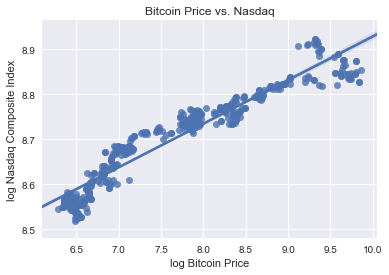

In [20]:
# FEATURE ANALYSIS: NASDAQ COMPOSITE INDEX
x = df['logBTCPrice']
y = df['logNasdaq']

ax = sns.regplot(x,y, data=df)
ax.set(xlabel='log Bitcoin Price', ylabel='log Nasdaq Composite Index', title = 'Bitcoin Price vs. Nasdaq')
plt.savefig('charts/nasdaqvsbtcprice.png')

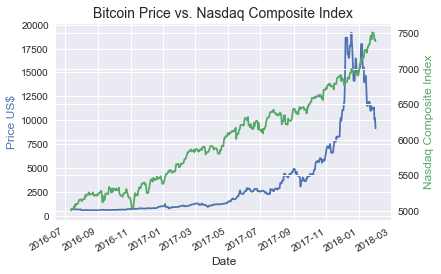

None


In [21]:
y1 = pd.Series(df_hist['BTCPrice'])
y2 = pd.Series(df_hist['Nasdaq'])
x = pd.Series(df_hist.index.values)

fig, _ = plt.subplots()

ax = plt.gca()
ax2 = ax.twinx()

ax.plot(x,y1,'b')
ax2.plot(x,y2,'g')
ax.set_ylabel("Price US$",color='b',fontsize=12)
ax2.set_ylabel("Nasdaq Composite Index",color='g',fontsize=12)
# ax.grid(True)
plt.title("Bitcoin Price vs. Nasdaq Composite Index", fontsize=14)
ax.set_xlabel('Date', fontsize=12)
fig.autofmt_xdate()
# ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

plt.savefig('charts/nasdaq.png')
print(plt.show())

In [22]:
y, X = patsy.dmatrices('logBTCPrice ~ logNasdaq', data=df, return_type="dataframe")

# Create your model
model3 = sm.OLS(y,X)
# Fit your model to your training set
fit3 = model3.fit()
# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     5209.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):          9.96e-255
Time:                        14:24:34   Log-Likelihood:                -93.295
No. Observations:                 467   AIC:                             190.6
Df Residuals:                     465   BIC:                             198.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -74.7172      1.140    -65.523      0.000     -76.958     -72.476
logNasdaq      9.4659      0.131     72.170      0.000       9.208       9.724
==============================================================================
Omnibus:                       24.376   Durbin-Watson:                   0.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.738
Skew:                           0.560   Prob(JB):                     1.56e-06
Kurtosis:                       3.348   Cond. No.                         733.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

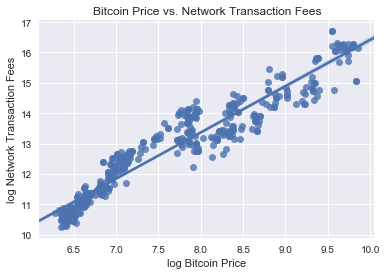

In [23]:
# FEATURE ANALYSIS: TRANSACTION FEES
x = df['logBTCPrice']
y = df['logTxFees']

ax = sns.regplot(x,y, data=df)
ax.set(xlabel='log Bitcoin Price', ylabel='log Network Transaction Fees', title = 'Bitcoin Price vs. Network Transaction Fees')
plt.savefig('charts/txfeesvsbtcprice.png')

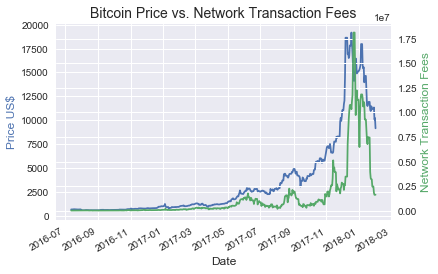

None


In [24]:
y1 = pd.Series(df_hist['BTCPrice'])
y2 = pd.Series(df_hist['TxFees'])
x = pd.Series(df_hist.index.values)

fig, _ = plt.subplots()

ax = plt.gca()
ax2 = ax.twinx()

ax.plot(x,y1,'b')
ax2.plot(x,y2,'g')
ax.set_ylabel("Price US$",color='b',fontsize=12)
ax2.set_ylabel("Network Transaction Fees",color='g',fontsize=12)
# ax.grid(True)
plt.title("Bitcoin Price vs. Network Transaction Fees", fontsize=14)
ax.set_xlabel('Date', fontsize=12)
fig.autofmt_xdate()
# ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

plt.savefig('charts/txfees.png')
print(plt.show())

In [25]:
y, X = patsy.dmatrices('logBTCPrice ~ logTxFees', data=df, return_type="dataframe")

# Create your model
model4 = sm.OLS(y,X)
# Fit your model to your training set
fit4 = model4.fit()
# Print summary statistics of the model's performance
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     5203.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):          1.25e-254
Time:                        14:24:35   Log-Likelihood:                -93.521
No. Observations:                 467   AIC:                             191.0
Df Residuals:                     465   BIC:                             199.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0781      0.107     -0.730      0.466      -0.288       0.132
logTxFees      0.6018      0.008     72.132      0.000       0.585       0.618
==============================================================================
Omnibus:                        3.814   Durbin-Watson:                   0.213
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                3.720
Skew:                           0.177   Prob(JB):                        0.156
Kurtosis:                       2.744   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regularization
Regularization has been considered but not included in the model.  The model is highly correlated with the price of 
Bitcoin, achieved with only 3 features.  Even with a further reduction of features the model remains highly correlated.  Per the simply RidgeCV analysis below, the model is also not overfit.

However, given the large Condition Number and resulting Multicollinearity, regularization may be used to further address this issue.  

In [26]:
# REGULARIZATION
from sklearn.linear_model import RidgeCV

rcv = RidgeCV(cv=10)

rcv.fit(X_train, y_train)
print(rcv.score(X_train,y_train))
rcv.score(X_test, y_test)

0.9671757358578132


0.969723969542316